# Squeezed state

This notebook illustrates the simplest example: the reconstruction of the covariance matrix of a squeezed state.

In [9]:
from phase_scan import gaussian_utils
from phase_scan.ml_estimation import ml_covariance_estimation, ml_covariance_estimation_direct_ls
from phase_scan.utils import triangle

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import rc

import numpy as np
import scipy as sp
from scipy.stats import norm

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

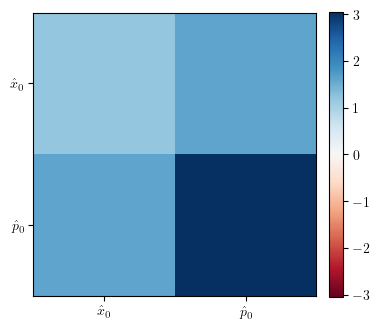

In [10]:
squeezing_dB = 6
squeezing_angle = np.pi / 6

squeezing_s = 10 ** (-squeezing_dB / 10)
sigma = gaussian_utils.squeezed_vacuum(squeezing_s)
R = gaussian_utils.rotation_symplectic(squeezing_angle)
sigma = R@sigma@R.T

gaussian_utils.plot_covariance_matrix(sigma, show_var_names=True)
plt.show()

## Quadrature samples obtained by scanning

We simulate here the slow modulation of the LO phase to rotate the measured quadrature. For each value of the angle, 1000 quadrature samples are acquired.

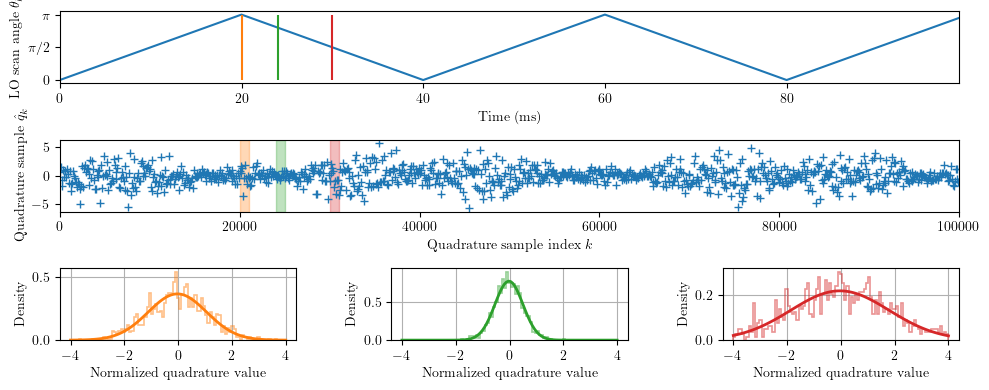

In [11]:
N_angles = 100
t = np.arange(N_angles) / N_angles * 100
angles = np.pi * triangle(t / 100, 2.5)

data = gaussian_utils.generate_scanned_samples(
    sigma,
    angles,
    gaussian_utils.generate_samples_parallel,
    samples_per_angle=1000)

# Plot the quadrature samples, and their distribution for different angles.
fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1], figure=fig, hspace=0.5)
axs = [fig.add_subplot(gs[i, 0]) for i in range(2)]

axs[0].plot(t, angles)
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('LO scan angle $\\theta_k$')
axs[0].set_xlim([0, max(t)])
axs[0].set_yticks([0, np.pi / 2, np.pi], ['0', '$\\pi / 2$', '$\\pi$'])

all_samples = np.concatenate([samples for _, samples in data])
indices = np.arange(len(all_samples))
axs[1].plot(indices[::100], all_samples[::100], '+')
axs[1].set_xlabel('Quadrature sample index $k$')
axs[1].set_ylabel('Quadrature sample $\\hat{q}_k$')
axs[1].set_xlim([0, len(all_samples)])

gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[2], wspace=0.4)
bottom_axs = [fig.add_subplot(gs_bottom[0, i]) for i in range(3)]

for i, t_index in enumerate([20, 24, 30]):
    block_samples = data[t_index][1]
    axs[0].vlines(t_index, 0, np.pi, f'C{i + 1}')
    axs[1].axvspan(1000*t[t_index], 1000*t[t_index + 1], color=f'C{i + 1}', alpha=0.3)

    x_vals = np.linspace(-4, 4, 100)
    bottom_axs[i].hist(block_samples, x_vals, density=True, histtype='step', color=f'C{i + 1}', linewidth=1.2, alpha=0.5)
    mu, std = norm.fit(block_samples)
    bottom_axs[i].plot(x_vals, norm.pdf(x_vals, mu, std), color=f'C{i + 1}', linewidth=2, label=f'fit')
    bottom_axs[i].set_xlabel("Normalized quadrature value")
    bottom_axs[i].set_ylabel("Density")
    bottom_axs[i].grid(True)

gs.tight_layout(fig)
plt.show()

## Covariance matrix reconstruction

The covariance matrix can now be reconstructed from the quadrature data.

Optimizing...:   0%|          | 0/1000 [00:00<?, ?it/s]

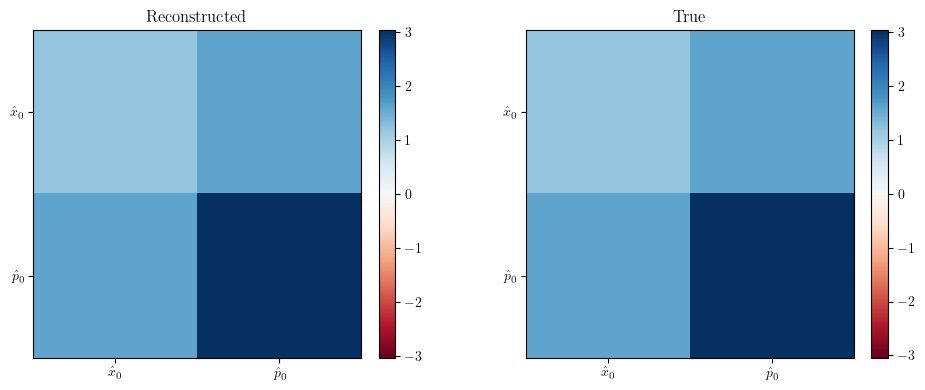

In [13]:
N_angles = 100
t = np.arange(N_angles) / N_angles * 100
angles = np.pi * triangle(t / 100, 2.5)

data = gaussian_utils.generate_scanned_samples(
    sigma,
    angles,
    gaussian_utils.generate_samples_parallel,
    samples_per_angle=1000)

estimated_sigma = ml_covariance_estimation(data, lr=0.05, max_iterations=1_000)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
gaussian_utils.plot_covariance_matrix(sigma, title='True', show_var_names=True, sequential=False, axs=axs[1])
gaussian_utils.plot_covariance_matrix(estimated_sigma, title='Reconstructed', show_var_names=True, sequential=False, axs=axs[0]) 
plt.tight_layout()
plt.show()

### And now with least squares

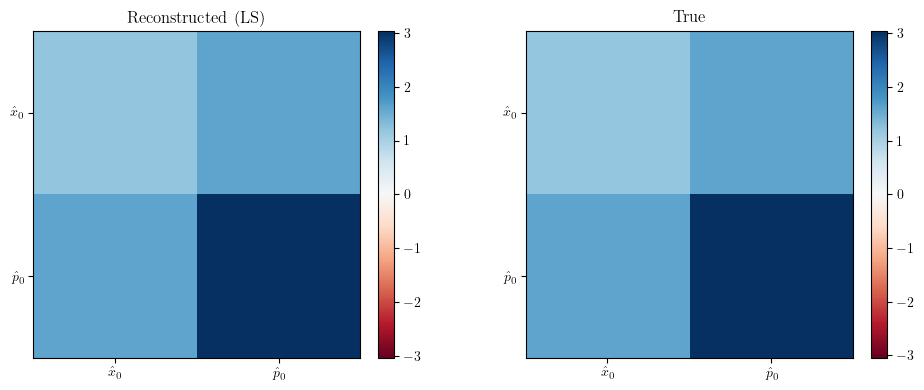

In [16]:
estimated_sigma_ls = ml_covariance_estimation_direct_ls(data)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
gaussian_utils.plot_covariance_matrix(sigma, title='True', show_var_names=True, sequential=False, axs=axs[1])
gaussian_utils.plot_covariance_matrix(estimated_sigma, title='Reconstructed (LS)', show_var_names=True, sequential=False, axs=axs[0]) 
plt.tight_layout()
plt.show()